In [ ]:
#!pip install -r "/content/drive/MyDrive/Colab Notebooks/LEVX_1km/requirements.txt"

In [1]:
#@title Load coordinates nearest points
import plotly.express as px
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import time
from sklearn.pipeline import Pipeline
import pickle
from scipy.stats import chi2_contingency

pd.options.display.max_rows = 999


coor=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/airport_ml/LEVX/input_files/distan_lat42.22lon-8.63p2R1Km.csv")
px.set_mapbox_access_token("pk.eyJ1IjoiZ3JhbmFudHVpbiIsImEiOiJja3B4dGU4OTkwMTFmMm9ycnNhMjJvaGJqIn0.VWzx_PkD9A5cSUVsn_ijCA")
px.scatter_mapbox(coor, hover_data=['distance'],lat='lat', lon='lon',color='distance', title="Nearest points",
                           color_continuous_scale=px.colors.cyclical.IceFire,)

Weather frequencies


M                 74.77%
BCFG               6.82%
FG                 3.39%
-RA                2.08%
RA                 1.37%
BR                 1.35%
-RA BCFG           1.02%
RA BCFG            0.89%
RA BR              0.62%
RA FG              0.55%
-RA BR             0.52%
BCFG -RA           0.49%
-RA FG             0.48%
SHRA               0.38%
BCFG RA            0.36%
-DZ                0.30%
VCFG               0.28%
DZ                 0.28%
BCFG -DZ           0.24%
-DZ BCFG           0.19%
FG DZ              0.18%
-DZ FG             0.18%
FG -RA             0.17%
BCFG DZ            0.17%
FG -DZ             0.17%
DZ BCFG            0.16%
-RADZ              0.16%
DZ FG              0.14%
-RADZ BCFG         0.14%
FG RA              0.12%
-DZ BR             0.11%
-SHRA              0.11%
DZ BR              0.11%
+RA FG             0.10%
-RADZ FG           0.09%
-RADZ BR           0.09%
VCTS               0.09%
+RA BCFG           0.08%
TS                 0.08%
BCFG -RADZ         0.07%


*****************************
Climatology RA or DZ


No RA/DZ    87%
RA/DZ       13%
Name: prec_l, dtype: object

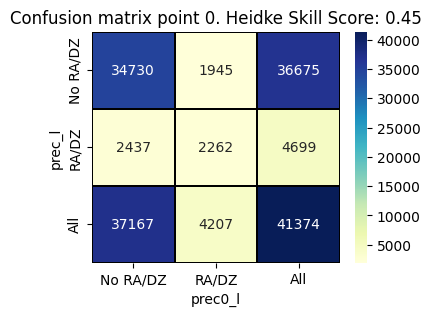

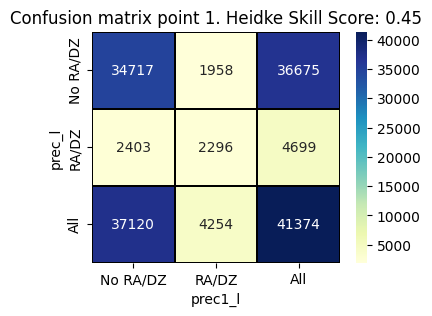

Chi2 contingency test

p-value: 0.0
Significance level: 0.01
Degres of of freedom:  1
Statistic 8362.155961170858
Reject H0,There is an association between meteorological model forecast and observed values


In [2]:
#@title Load station (visibility). Load meteorological model forecast D0. Display relation visibility with model variables. Heidke skill score (HSS) meteorological model
station = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/airport_ml/LEVX/input_files/LEVXY2018Y2022.csv",
                          usecols =["time","wxcodes_o"],
                          parse_dates=["time"]).dropna().set_index("time")

print("Weather frequencies")
display(station["wxcodes_o"].value_counts(normalize=True).map(lambda n: '{:.2%}'.format(n)))

station["prec_l"] = "No RA/DZ"
mask = station['wxcodes_o'].str.contains("RA")
station.loc[mask,["prec_l"]] = "RA/DZ"
mask = station['wxcodes_o'].str.contains("DZ")
station.loc[mask,["prec_l"]] = "RA/DZ"
station["prec_l"]=pd.Categorical(station["prec_l"])

#display(station.sample(50).head(20))
print("*****************************")
print("Climatology RA or DZ")
display(station["prec_l"].value_counts(normalize=True).map(lambda n: '{:.0%}'.format(n)))

#Load
mody2018 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/airport_ml/LEVX/input_files/lat42.22lon-8.63p2R1KmD0Y2018.csv",parse_dates=["time"])
mody2019 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/airport_ml/LEVX/input_files/lat42.22lon-8.63p2R1KmD0Y2019.csv",parse_dates=["time"])
mody2020 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/airport_ml/LEVX/input_files/lat42.22lon-8.63p2R1KmD0Y2020.csv",parse_dates=["time"])
mody2021 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/airport_ml/LEVX/input_files/lat42.22lon-8.63p2R1KmD0Y2021.csv",parse_dates=["time"])
mody2022 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/airport_ml/LEVX/input_files/lat42.22lon-8.63p2R1KmD0Y2022.csv",parse_dates=["time"])
model = pd.concat([mody2018,mody2019,mody2020,mody2021,mody2022]).drop(columns=["Unnamed: 0"]).set_index("time")

#concat station file versus meteorological model file same time
df_all = pd.concat([station,model],axis=1).dropna()
#display(df_all)


#label meteorological model variables prec0 and prec1
df_all["prec0_l"] = pd.Categorical(np.asarray(["RA/DZ" if c>0.1 else "No RA/DZ" for c in df_all.prec0]))
df_all["prec1_l"] = pd.Categorical(np.asarray(["RA/DZ" if c>0.1 else "No RA/DZ" for c in df_all.prec1]))

# Confussion matrix and Heidke skill score
cm0 = pd.crosstab(df_all.prec_l, df_all.prec0_l,margins=True)
a = cm0.values[0,0]
b = cm0.values[1,0]
c = cm0.values[0,1]
d = cm0.values[1,1]
HSS0 = round(2*(a*d-b*c)/((a+c)*(c+d)+(a+b)*(b+d)),2)


cm1 = pd.crosstab(df_all.prec_l, df_all.prec1_l,margins=True)
a = cm1.values[0,0]
b = cm1.values[1,0]
c = cm1.values[0,1]
d = cm1.values[1,1]
HSS1 = round(2*(a*d-b*c)/((a+c)*(c+d)+(a+b)*(b+d)),2)

plt.figure(figsize=(4, 3))
plt.title("Confusion matrix point 0. Heidke Skill Score: {}".format(HSS0))
seab0 = sns.heatmap(cm0,annot=True,cmap="YlGnBu",fmt='.0f',linewidths=.2,linecolor='black');
plt.show()

plt.figure(figsize=(4, 3))
plt.title("Confusion matrix point 1. Heidke Skill Score: {}".format(HSS1))
seab1 = sns.heatmap(cm1,annot=True,cmap="YlGnBu",fmt='.0f',linewidths=.2,linecolor='black');
plt.show()

#stadistic(sta), pvalue (p), degrees of freedom (dof) and expected values (exp)
sta, p, dof, exp = chi2_contingency(cm0.iloc[0:2,0:2])

#degrees of freedoom (rows-1)*(columns-1) to test association between two variables
alpha = 0.01
print("Chi2 contingency test")
print('\np-value:',p)
print('Significance level:',alpha)
print('Degres of of freedom: ',dof)
print("Statistic",sta)

if p<=alpha:
    print("Reject H0,There is an association between meteorological model forecast and observed values")
else:
    print("Retain H0,There is no association between meteorological model and observed values")


Round 0
Round 1
Round 2
Round 3
Round 4
Round 5
Round 6
Round 7
Round 8
Round 9


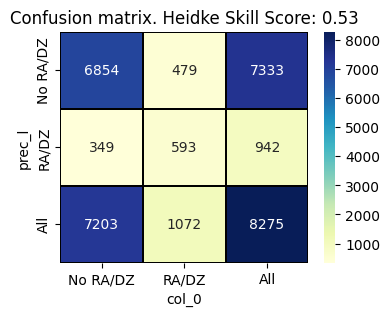

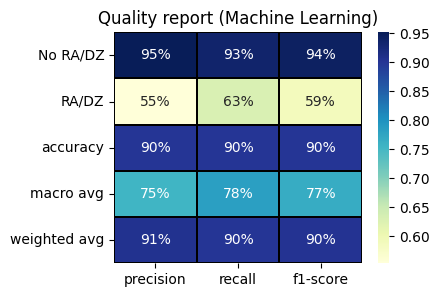

,feature,feature_per
52,dayofyear,3.6%
17,cfh0,3.4%
50,hour,3.2%
42,cfh1,2.9%
19,cfm0,2.7%
5,mslp0,2.5%
8,visibility0,2.5%
0,dir0,2.4%
2,snowlevel0,2.3%
25,dir1,2.3%



HSS stadistics
             HSS
count  10.000000
mean    0.539740
std     0.013638
min     0.509315
25%     0.535116
50%     0.540922
75%     0.548018
max     0.559935
Shapiro test normality
p value: 0.40499797463417053
Accept null hypothesis: normal distribution variable HSS in the samples
chi2_contingency last round
p-value: 0.0
Significance level: 0.01
Degres of of freedom:  1
Stadistic 2351.3720155516176
Reject H0,There is an association between machine learning forecast and observed values
Execution time: 1.65 minutes


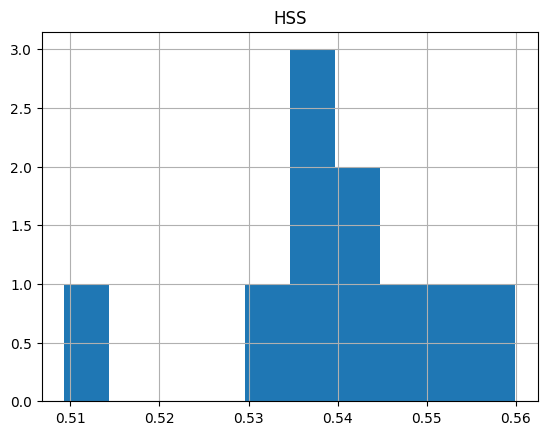

In [3]:
#@title ML LGBMClassifier. Samples 10. Heidke Skill score.

from lightgbm.sklearn import LGBMClassifier
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report
from scipy.stats import shapiro


start_time = time.time()

df_all["hour"] = df_all.index.hour
df_all["month"] = df_all.index.month
df_all["dayofyear"] = df_all.index.dayofyear
df_all["weekofyear"] = df_all.index.isocalendar().week.astype(int)

#random seed 1
np.random.seed(31)

# X and Y
Y = df_all.prec_l
X = df_all.iloc[:,2:].drop(columns=['prec0_l', 'prec1_l'])


# loop random
HSS = []
for t in range (0,10):
  print("Round",t)
  #split variables
  X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.2, )

  # Resample
  X_res, y_res = SMOTE().fit_resample(X_train,y_train)

  #train model
  ml_model = LGBMClassifier(n_estimators=200).fit(X_res,y_res)

  #Confusion matrix
  cm = pd.crosstab(y_test, ml_model.predict(X_test),margins=True,)
  a = cm.values[0,0]
  b = cm.values[1,0]
  c = cm.values[0,1]
  d = cm.values[1,1]
  HSS.append(2*(a*d-b*c)/((a+c)*(c+d)+(a+b)*(b+d)))
  if t==9:
    plt.figure(figsize=(4, 3))
    plt.title("Confusion matrix. Heidke Skill Score: {}".format(round(HSS[t],2)))
    seab = sns.heatmap(cm,annot=True,cmap="YlGnBu",fmt='.0f',linewidths=.2,linecolor='black');
    plt.show()

    #quality report
    plt.figure(figsize=(4, 3))
    plt.title("Quality report (Machine Learning)")
    qr = pd.DataFrame(classification_report(y_test, ml_model.predict(X_test),output_dict=True)).T
    seab = sns.heatmap(qr.iloc[:,:-1],annot=True,cmap="YlGnBu",fmt='.0%',linewidths=.2,linecolor='black');
    plt.show()

    #feature importance
    def format_as_percentage(value):
        return '{:.1%}'.format(value)
    fea_imp =pd.DataFrame({"feature":X.columns,
                        "importance":[(importance/(sum(ml_model.feature_importances_))) for importance in ml_model.feature_importances_]})
    fea_imp["feature_per"] =  fea_imp['importance'].map(format_as_percentage)
    fea_sort = fea_imp.sort_values(by="importance",ascending=False)
    display(fea_sort[["feature","feature_per"]][:10])



print("\nHSS stadistics")
# if p-value is lower than 5%, we can reject the null hypothesis of the normality of the dataset

print(pd.DataFrame(HSS,columns=["HSS"]).describe())

#sample less 5000
sta, p = shapiro(HSS)
print("Shapiro test normality")
print("p value:",p)
#significance level alpha=0.01
alpha = 0.01
if p>alpha:
  print("Accept null hypothesis: normal distribution variable HSS in the samples")
else:
  print("Reject null Hypothesis. Alternative hypothesis variable HSS no normal distribution in samples")



pd.DataFrame(HSS,columns=["HSS"]).hist();

#stadistic(sta), pvalue (p), degrees of freedom (dof) and expected values (exp)
print("chi2_contingency last round")
sta, p, dof, exp = chi2_contingency(cm.iloc[0:2,0:2])

#degrees of freedoom (rows-1)*(columns-1) to test associationbetween two variables
alpha = 0.01
print('p-value:',p)
print('Significance level:',alpha)
print('Degres of of freedom: ',dof)
print("Stadistic",sta)

if p<=alpha:
    print("Reject H0,There is an association between machine learning forecast and observed values")
else:
    print("Retain H0,There is no association between machine learning forecast and observed values")

#time
end_time = time.time()
execution_time = end_time - start_time
print("Execution time:", round(execution_time/60,2), "minutes")




In [4]:
#@title Save last algorithm round 9


x_var = X.columns
score = {"HSS_ml":HSS[-1],"HSS_met":HSS0}
estimators = [('ml_model', ml_model)]
pipe = Pipeline(estimators)

al_file={"x_var":x_var,"coor":coor,"pipe":pipe,"score":score}
pickle.dump(al_file, open("/content/drive/MyDrive/Colab Notebooks/airport_ml/LEVX/algorithms/prec_LEVX_d0.al", 'wb'))

Round 0
Round 1
Round 2
Round 3
Round 4
Round 5
Round 6
Round 7
Round 8
Round 9


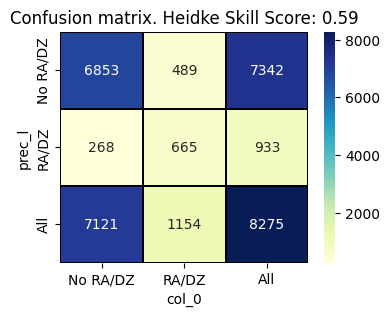

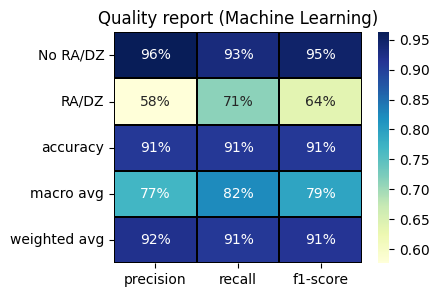

,feature,feature_per
18,cfl0,10.2%
45,cft1,8.7%
43,cfl1,7.4%
20,cft0,6.5%
44,cfm1,4.9%
19,cfm0,4.2%
35,lwflx1,3.0%
10,lwflx0,2.7%
7,rh0,2.7%
32,rh1,2.5%



HSS stadistics
             HSS
count  10.000000
mean    0.581711
std     0.009601
min     0.560883
25%     0.576035
50%     0.584874
75%     0.587701
max     0.593206
Shapiro test normality
p value: 0.29197394847869873
Accept null hypothesis: normal distribution variable HSS in the samples
chi2_contingency last round
p-value: 0.0
Significance level: 0.01
Degres of of freedom:  1
Stadistic 2874.5744552085016
Reject H0,There is an association between machine learning forecast and observed values
Execution time: 1.99 minutes


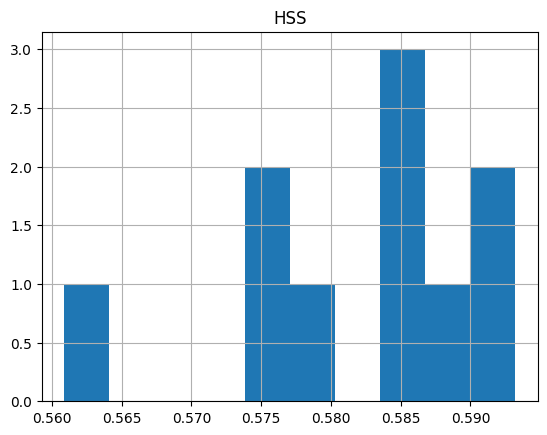

In [5]:
#@title ML RandomForestClassifier. Samples 10. Heidke Skill score.
from lightgbm.sklearn import LGBMClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Perceptron
from sklearn.tree import ExtraTreeClassifier
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report
from scipy.stats import shapiro

start_time = time.time()

#random seed 1
np.random.seed(31)

# X and Y
Y = df_all.prec_l
X = df_all.iloc[:,2:].drop(columns=['prec0_l', 'prec1_l'])


# loop random
HSS_E = []
for t in range (0,10):
  print("Round",t)
  #split variables
  X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.2, )

  # Resample
  X_res, y_res = SMOTE().fit_resample(X_train,y_train)

  #train model
  #ml_model = LGBMClassifier(n_estimators=200).fit(X_res,y_res)
  ml_model = ExtraTreesClassifier().fit(X_res,y_res)
  #ml_model = Perceptron().fit(X_res,y_res)
  #ml_model = RandomForestClassifier().fit(X_res,y_res)

  #Confusion matrix
  cm = pd.crosstab(y_test, ml_model.predict(X_test),margins=True,)
  a = cm.values[0,0]
  b = cm.values[1,0]
  c = cm.values[0,1]
  d = cm.values[1,1]
  HSS_E.append(2*(a*d-b*c)/((a+c)*(c+d)+(a+b)*(b+d)))
  if t==9:
    plt.figure(figsize=(4, 3))
    plt.title("Confusion matrix. Heidke Skill Score: {}".format(round(HSS_E[t],2)))
    seab = sns.heatmap(cm,annot=True,cmap="YlGnBu",fmt='.0f',linewidths=.2,linecolor='black');
    plt.show()

    #quality report
    plt.figure(figsize=(4, 3))
    plt.title("Quality report (Machine Learning)")
    qr = pd.DataFrame(classification_report(y_test, ml_model.predict(X_test),output_dict=True)).T
    seab = sns.heatmap(qr.iloc[:,:-1],annot=True,cmap="YlGnBu",fmt='.0%',linewidths=.2,linecolor='black');
    plt.show()

    #feature importance
    def format_as_percentage(value):
       return '{:.1%}'.format(value)
    fea_imp =pd.DataFrame({"feature":X.columns,
                        "importance":[(importance/(sum(ml_model.feature_importances_))) for importance in ml_model.feature_importances_]})
    fea_imp["feature_per"] =  fea_imp['importance'].map(format_as_percentage)
    fea_sort = fea_imp.sort_values(by="importance",ascending=False)
    display(fea_sort[["feature","feature_per"]][:10])

print("\nHSS stadistics")
# if p-value is lower than 5%, we can reject the null hypothesis of the normality of the dataset

print(pd.DataFrame(HSS_E,columns=["HSS"]).describe())

#sample less 5000
sta, p = shapiro(HSS_E)
print("Shapiro test normality")
print("p value:",p)
#significance level alpha=0.01
alpha = 0.01
if p>alpha:
  print("Accept null hypothesis: normal distribution variable HSS in the samples")
else:
  print("Reject null Hypothesis. Alternative hypothesis variable HSS no normal distribution in samples")



pd.DataFrame(HSS_E,columns=["HSS"]).hist();

#stadistic(sta), pvalue (p), degrees of freedom (dof) and expected values (exp)
print("chi2_contingency last round")
sta, p, dof, exp = chi2_contingency(cm.iloc[0:2,0:2])

#degrees of freedoom (rows-1)*(columns-1) to test associationbetween two variables
alpha = 0.01
print('p-value:',p)
print('Significance level:',alpha)
print('Degres of of freedom: ',dof)
print("Stadistic",sta)

if p<=alpha:
    print("Reject H0,There is an association between machine learning forecast and observed values")
else:
    print("Retain H0,There is no association between machine learning forecast and observed values")

#time
end_time = time.time()
execution_time = end_time - start_time
print("Execution time:", round(execution_time/60,2), "minutes")







In [ ]:
#@title Save last heavy algorithm round 9
x_var = X.columns
score = {"HSS_ml":HSS_E[-1],"HSS_met":HSS0}
estimators = [('ml_model', ml_model)]
pipe = Pipeline(estimators)

al_file={"x_var":x_var,"coor":coor,"pipe":pipe,"score":score}
pickle.dump(al_file, open("/content/drive/MyDrive/Colab Notebooks/airport_ml/LEVX/algorithms/prec_LEVX_d0.al", 'wb'))

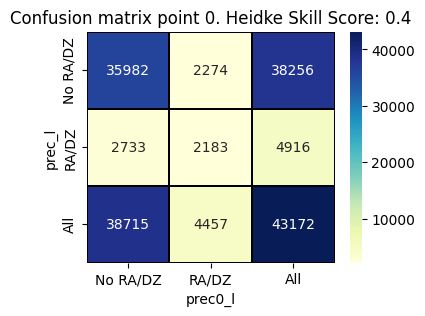

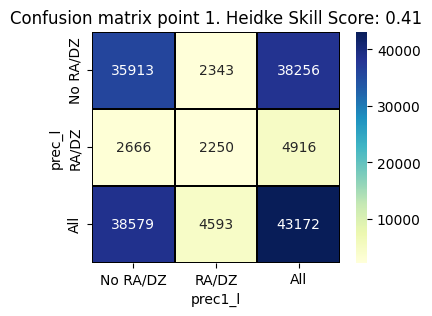

Chi2 contingency test

p-value: 0.0
Significance level: 0.01
Degres of of freedom:  1
Statistic 6956.534186561669
Reject H0,There is an association between meteorological model forecast and observed values


In [6]:
#@title Load meteorological model forecast D1.Display relation visibility with model variables. Heidke skill score (HSS) meteorological model
#Load
mody2018 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/airport_ml/LEVX/input_files/lat42.22lon-8.63p2R1KmD1Y2018.csv",parse_dates=["time"])
mody2019 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/airport_ml/LEVX/input_files/lat42.22lon-8.63p2R1KmD1Y2019.csv",parse_dates=["time"])
mody2020 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/airport_ml/LEVX/input_files/lat42.22lon-8.63p2R1KmD1Y2020.csv",parse_dates=["time"])
mody2021 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/airport_ml/LEVX/input_files/lat42.22lon-8.63p2R1KmD1Y2021.csv",parse_dates=["time"])
mody2022 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/airport_ml/LEVX/input_files/lat42.22lon-8.63p2R1KmD1Y2022.csv",parse_dates=["time"])
model = pd.concat([mody2018,mody2019,mody2020,mody2021,mody2022]).drop(columns=["Unnamed: 0"]).set_index("time")

#concat station file versus meteorological model file same time
df_all = pd.concat([station,model],axis=1).dropna()
#display(df_all)


#label meteorological model variables prec0 and prec1
df_all["prec0_l"] = pd.Categorical(np.asarray(["RA/DZ" if c>0.1 else "No RA/DZ" for c in df_all.prec0]))
df_all["prec1_l"] = pd.Categorical(np.asarray(["RA/DZ" if c>0.1 else "No RA/DZ" for c in df_all.prec1]))

# Confussion matrix and Heidke skill score
cm0 = pd.crosstab(df_all.prec_l, df_all.prec0_l,margins=True)
a = cm0.values[0,0]
b = cm0.values[1,0]
c = cm0.values[0,1]
d = cm0.values[1,1]
HSS0 = round(2*(a*d-b*c)/((a+c)*(c+d)+(a+b)*(b+d)),2)


cm1 = pd.crosstab(df_all.prec_l, df_all.prec1_l,margins=True)
a = cm1.values[0,0]
b = cm1.values[1,0]
c = cm1.values[0,1]
d = cm1.values[1,1]
HSS1 = round(2*(a*d-b*c)/((a+c)*(c+d)+(a+b)*(b+d)),2)

plt.figure(figsize=(4, 3))
plt.title("Confusion matrix point 0. Heidke Skill Score: {}".format(HSS0))
seab0 = sns.heatmap(cm0,annot=True,cmap="YlGnBu",fmt='.0f',linewidths=.2,linecolor='black');
plt.show()

plt.figure(figsize=(4, 3))
plt.title("Confusion matrix point 1. Heidke Skill Score: {}".format(HSS1))
seab1 = sns.heatmap(cm1,annot=True,cmap="YlGnBu",fmt='.0f',linewidths=.2,linecolor='black');
plt.show()

#stadistic(sta), pvalue (p), degrees of freedom (dof) and expected values (exp)
sta, p, dof, exp = chi2_contingency(cm0.iloc[0:2,0:2])

#degrees of freedoom (rows-1)*(columns-1) to test association between two variables
alpha = 0.01
print("Chi2 contingency test")
print('\np-value:',p)
print('Significance level:',alpha)
print('Degres of of freedom: ',dof)
print("Statistic",sta)

if p<=alpha:
    print("Reject H0,There is an association between meteorological model forecast and observed values")
else:
    print("Retain H0,There is no association between meteorological model and observed values")


Round 0
Round 1
Round 2
Round 3
Round 4
Round 5
Round 6
Round 7
Round 8
Round 9


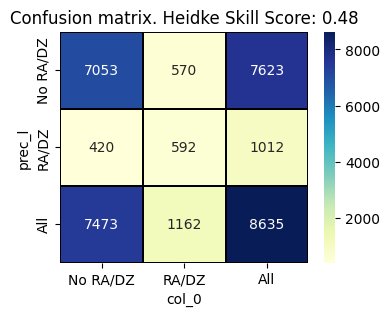

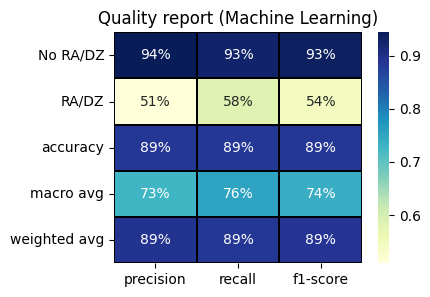

,feature,feature_per
52,dayofyear,4.0%
42,cfh1,3.5%
50,hour,3.2%
17,cfh0,3.2%
0,dir0,2.6%
25,dir1,2.6%
5,mslp0,2.5%
44,cfm1,2.5%
8,visibility0,2.5%
16,cin0,2.4%



HSS stadistics
             HSS
count  10.000000
mean    0.487718
std     0.013074
min     0.459782
25%     0.483749
50%     0.485274
75%     0.495687
max     0.505277
Shapiro test normality
p value: 0.3588968813419342
Accept null hypothesis: normal distribution variable HSS in the samples
chi2_contingency last round
p-value: 0.0
Significance level: 0.01
Degres of of freedom:  1
Stadistic 1992.5369148777772
Reject H0,There is an association between machine learning forecast and observed values
Execution time: 1.43 minutes


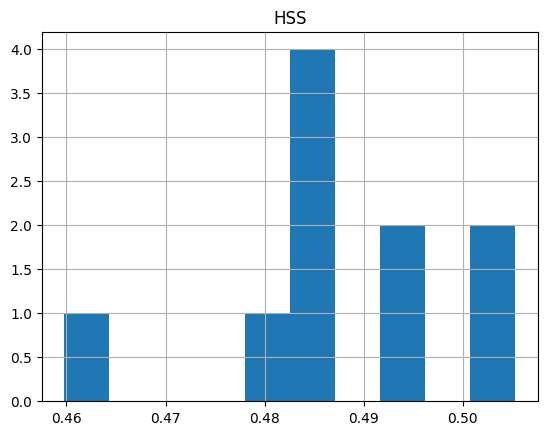

In [7]:
#@title ML LGBMClassifier. Samples 10. Heidke Skill score
start_time = time.time()

df_all["hour"] = df_all.index.hour
df_all["month"] = df_all.index.month
df_all["dayofyear"] = df_all.index.dayofyear
df_all["weekofyear"] = df_all.index.isocalendar().week.astype(int)

#random seed 1
np.random.seed(31)

# X and Y
Y = df_all.prec_l
X = df_all.iloc[:,2:].drop(columns=['prec0_l', 'prec1_l'])


# loop random
HSS = []
for t in range (0,10):
  print("Round",t)
  #split variables
  X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.2, )

  # Resample
  X_res, y_res = SMOTE().fit_resample(X_train,y_train)

  #train model
  ml_model = LGBMClassifier(n_estimators=200).fit(X_res,y_res)

  #Confusion matrix
  cm = pd.crosstab(y_test, ml_model.predict(X_test),margins=True,)
  a = cm.values[0,0]
  b = cm.values[1,0]
  c = cm.values[0,1]
  d = cm.values[1,1]
  HSS.append(2*(a*d-b*c)/((a+c)*(c+d)+(a+b)*(b+d)))
  if t==9:
    plt.figure(figsize=(4, 3))
    plt.title("Confusion matrix. Heidke Skill Score: {}".format(round(HSS[t],2)))
    seab = sns.heatmap(cm,annot=True,cmap="YlGnBu",fmt='.0f',linewidths=.2,linecolor='black');
    plt.show()

    #quality report
    plt.figure(figsize=(4, 3))
    plt.title("Quality report (Machine Learning)")
    qr = pd.DataFrame(classification_report(y_test, ml_model.predict(X_test),output_dict=True)).T
    seab = sns.heatmap(qr.iloc[:,:-1],annot=True,cmap="YlGnBu",fmt='.0%',linewidths=.2,linecolor='black');
    plt.show()

    #feature importance
    def format_as_percentage(value):
        return '{:.1%}'.format(value)
    fea_imp =pd.DataFrame({"feature":X.columns,
                        "importance":[(importance/(sum(ml_model.feature_importances_))) for importance in ml_model.feature_importances_]})
    fea_imp["feature_per"] =  fea_imp['importance'].map(format_as_percentage)
    fea_sort = fea_imp.sort_values(by="importance",ascending=False)
    display(fea_sort[["feature","feature_per"]][:10])



print("\nHSS stadistics")
# if p-value is lower than 5%, we can reject the null hypothesis of the normality of the dataset

print(pd.DataFrame(HSS,columns=["HSS"]).describe())

#sample less 5000
sta, p = shapiro(HSS)
print("Shapiro test normality")
print("p value:",p)
#significance level alpha=0.01
alpha = 0.01
if p>alpha:
  print("Accept null hypothesis: normal distribution variable HSS in the samples")
else:
  print("Reject null Hypothesis. Alternative hypothesis variable HSS no normal distribution in samples")



pd.DataFrame(HSS,columns=["HSS"]).hist();

#stadistic(sta), pvalue (p), degrees of freedom (dof) and expected values (exp)
print("chi2_contingency last round")
sta, p, dof, exp = chi2_contingency(cm.iloc[0:2,0:2])

#degrees of freedoom (rows-1)*(columns-1) to test associationbetween two variables
alpha = 0.01
print('p-value:',p)
print('Significance level:',alpha)
print('Degres of of freedom: ',dof)
print("Stadistic",sta)

if p<=alpha:
    print("Reject H0,There is an association between machine learning forecast and observed values")
else:
    print("Retain H0,There is no association between machine learning forecast and observed values")

#time
end_time = time.time()
execution_time = end_time - start_time
print("Execution time:", round(execution_time/60,2), "minutes")



In [8]:
#@title Save last algorithm round 9

x_var = X.columns
score = {"HSS_ml":HSS[-1],"HSS_met":HSS0}
estimators = [('ml_model', ml_model)]
pipe = Pipeline(estimators)

al_file={"x_var":x_var,"coor":coor,"pipe":pipe,"score":score}
pickle.dump(al_file, open("/content/drive/MyDrive/Colab Notebooks/airport_ml/LEVX/algorithms/prec_LEVX_d1.al", 'wb'))


Round 0
Round 1
Round 2
Round 3
Round 4
Round 5
Round 6
Round 7
Round 8
Round 9


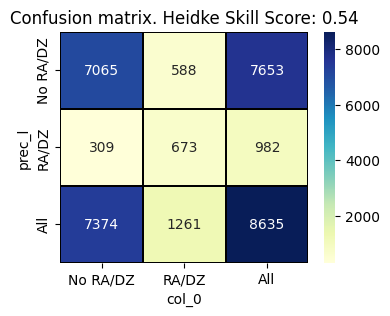

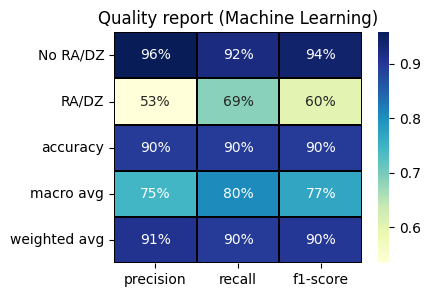

,feature,feature_per
43,cfl1,9.5%
18,cfl0,7.1%
45,cft1,7.1%
20,cft0,6.1%
44,cfm1,4.3%
19,cfm0,4.0%
35,lwflx1,2.7%
29,wind_gust1,2.5%
4,wind_gust0,2.3%
25,dir1,2.2%



HSS stadistics
             HSS
count  10.000000
mean    0.551135
std     0.011225
min     0.536290
25%     0.542089
50%     0.550520
75%     0.558208
max     0.571360
Shapiro test normality
p value: 0.7779138684272766
Accept null hypothesis: normal distribution variable HSS in the samples
chi2_contingency last round
p-value: 0.0
Significance level: 0.01
Degres of of freedom:  1
Stadistic 2579.247111649282
Reject H0,There is an association between machine learning forecast and observed values
Execution time: 1.84 minutes


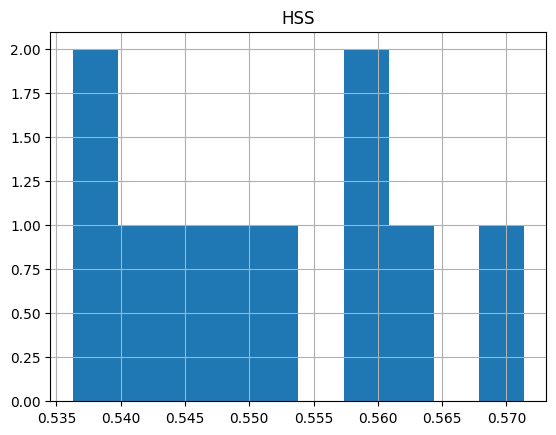

In [9]:
#@title ML RandomForestClassifier. Samples 10. Heidke Skill score.
from lightgbm.sklearn import LGBMClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Perceptron
from sklearn.tree import ExtraTreeClassifier
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report
from scipy.stats import shapiro

start_time = time.time()

#random seed 1
np.random.seed(31)

# X and Y
Y = df_all.prec_l
X = df_all.iloc[:,2:].drop(columns=['prec0_l', 'prec1_l'])


# loop random
HSS_E = []
for t in range (0,10):
  print("Round",t)
  #split variables
  X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.2, )

  # Resample
  X_res, y_res = SMOTE().fit_resample(X_train,y_train)

  #train model
  #ml_model = LGBMClassifier(n_estimators=200).fit(X_res,y_res)
  ml_model = ExtraTreesClassifier().fit(X_res,y_res)
  #ml_model = Perceptron().fit(X_res,y_res)
  #ml_model = RandomForestClassifier().fit(X_res,y_res)

  #Confusion matrix
  cm = pd.crosstab(y_test, ml_model.predict(X_test),margins=True,)
  a = cm.values[0,0]
  b = cm.values[1,0]
  c = cm.values[0,1]
  d = cm.values[1,1]
  HSS_E.append(2*(a*d-b*c)/((a+c)*(c+d)+(a+b)*(b+d)))
  if t==9:
    plt.figure(figsize=(4, 3))
    plt.title("Confusion matrix. Heidke Skill Score: {}".format(round(HSS_E[t],2)))
    seab = sns.heatmap(cm,annot=True,cmap="YlGnBu",fmt='.0f',linewidths=.2,linecolor='black');
    plt.show()

    #quality report
    plt.figure(figsize=(4, 3))
    plt.title("Quality report (Machine Learning)")
    qr = pd.DataFrame(classification_report(y_test, ml_model.predict(X_test),output_dict=True)).T
    seab = sns.heatmap(qr.iloc[:,:-1],annot=True,cmap="YlGnBu",fmt='.0%',linewidths=.2,linecolor='black');
    plt.show()

    #feature importance
    def format_as_percentage(value):
        return '{:.1%}'.format(value)
    fea_imp =pd.DataFrame({"feature":X.columns,
                        "importance":[(importance/(sum(ml_model.feature_importances_))) for importance in ml_model.feature_importances_]})
    fea_imp["feature_per"] =  fea_imp['importance'].map(format_as_percentage)
    fea_sort = fea_imp.sort_values(by="importance",ascending=False)
    display(fea_sort[["feature","feature_per"]][:10])

print("\nHSS stadistics")
# if p-value is lower than 5%, we can reject the null hypothesis of the normality of the dataset

print(pd.DataFrame(HSS_E,columns=["HSS"]).describe())

#sample less 5000
sta, p = shapiro(HSS_E)
print("Shapiro test normality")
print("p value:",p)
#significance level alpha=0.01
alpha = 0.01
if p>alpha:
  print("Accept null hypothesis: normal distribution variable HSS in the samples")
else:
  print("Reject null Hypothesis. Alternative hypothesis variable HSS no normal distribution in samples")



pd.DataFrame(HSS_E,columns=["HSS"]).hist();

#stadistic(sta), pvalue (p), degrees of freedom (dof) and expected values (exp)
print("chi2_contingency last round")
sta, p, dof, exp = chi2_contingency(cm.iloc[0:2,0:2])

#degrees of freedoom (rows-1)*(columns-1) to test associationbetween two variables
alpha = 0.01
print('p-value:',p)
print('Significance level:',alpha)
print('Degres of of freedom: ',dof)
print("Stadistic",sta)

if p<=alpha:
    print("Reject H0,There is an association between machine learning forecast and observed values")
else:
    print("Retain H0,There is no association between machine learning forecast and observed values")

#time
end_time = time.time()
execution_time = end_time - start_time
print("Execution time:", round(execution_time/60,2), "minutes")



In [ ]:
#@title Save last heavy algorithm round 9
x_var = X.columns
score = {"HSS_ml":HSS_E[-1],"HSS_met":HSS0}
estimators = [('ml_model', ml_model)]
pipe = Pipeline(estimators)

al_file={"x_var":x_var,"coor":coor,"pipe":pipe,"score":score}
pickle.dump(al_file, open("/content/drive/MyDrive/Colab Notebooks/airport_ml/LEVX/algorithms/prec_LEVX_d1.al", 'wb'))